In [1]:
from torch import nn, optim, device, set_grad_enabled, cuda, is_tensor, save 
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import gc, copy, joblib
import random as rand
import numpy as np
import torch
import time
import cv2

/home/olavo/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import torchvision
from torchvision.utils import make_grid

In [3]:
count = {}
with open("Imagens/count") as f:
    for line in f:
        (k, v) = line.split()
        count[k] = int(v)
indices = list(count.keys())

test_id = rand.sample(indices,202)
train_id = list(set(indices).difference(set(test_id)))



In [ ]:
my_transform = torchvision.transforms.Compose([ 
                       #torchvision.transforms.Resize(256), 
                       #torchvision.transforms.CenterCrop(224), 
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize(mean=91.12750025078802,
                                                         std=68.89707114427239)
#                        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                                         std=[0.229, 0.224, 0.225]),
                       ]
                     )

In [4]:

img_train = []
msk_train = []
for i in train_id:
    imagem = cv2.cvtColor(cv2.imread('Imagens/img/'+i+'.png'), cv2.COLOR_BGR2RGB)
    mascara = cv2.cvtColor(cv2.imread('Imagens/msk/'+i+'.png'), cv2.COLOR_BGR2GRAY)
    img_train.append(imagem)
    msk_train.append(mascara)

img_train = np.array(img_train)
msk_train = np.array(msk_train)

img_test = []
msk_test = []
for i in test_id:
    imagem = cv2.cvtColor(cv2.imread('Imagens/img/'+i+'.png'), cv2.COLOR_BGR2RGB)
    mascara = cv2.cvtColor(cv2.imread('Imagens/msk/'+i+'.png'), cv2.COLOR_BGR2GRAY)
    img_test.append(imagem)
    msk_test.append(mascara)

img_test = np.array(img_test)
msk_test = np.array(msk_test)

In [6]:
img_test.std()

68.89707114427239

In [4]:

img_train = torch.Tensor(img_train)
msk_train = torch.Tensor(msk_train)

img_test = torch.Tensor(img_test)
msk_test = torch.Tensor(msk_test)


img_train = TensorDataset(img_train,msk_train)
img_test = TensorDataset(img_test,msk_test)

img_train = DataLoader(dataset = img_train,batch_size=6,shuffle=True,pin_memory=True)
img_test = DataLoader(dataset = img_test,batch_size=6,shuffle=False,pin_memory=True)



21


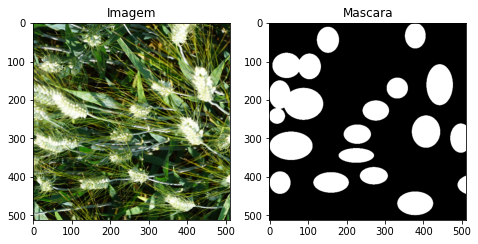

23


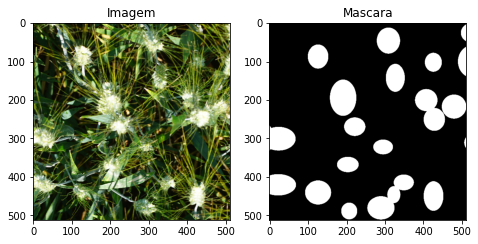

26


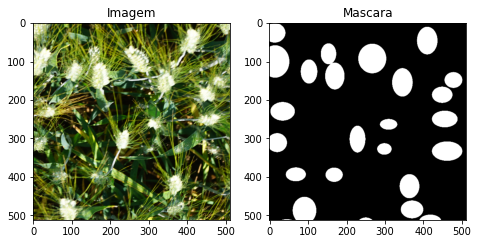

16


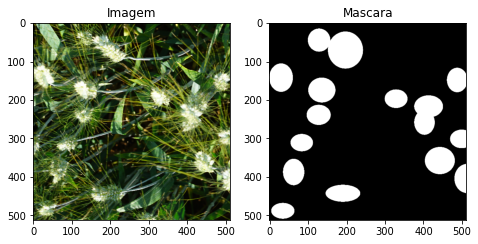

In [5]:
for i in range(30,34):
    
    fig = plt.figure(figsize=(12, 4))

    fig.add_subplot(1, 3, 1)
    plt.imshow(img[i])
    plt.title('Imagem')

    fig.add_subplot(1, 3, 2)
    plt.imshow(msk[i], cmap="gray")
    plt.title('Mascara')

    plt.show()

1200 para treino
e 216 para teste

In [6]:
class NNRegressor(nn.Module):
    
    def __init__(self,
                 lr=1e-3,
                 verbose=False
                ):
        super(NNRegressor, self).__init__()
        
        self.verbose = verbose
        
        if cuda.is_available():
            self.device = device('cuda')
            device_str = 'gpu'
        else:
            self.device = device('cpu')
            device_str = 'cpu'
            
        if self.verbose:
            print('Rodando em %s...' % device_str)
            
        in_channels=3   
        out_channels=1
        dim1 = 16
        dim2 = 32
        dim3 = 64
        dim4 = 128
            
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=dim1, kernel_size=(7,1), stride=1, padding=(3,0)),
            nn.Conv2d(in_channels=dim1, out_channels=dim1, kernel_size=(1,7), stride=1, padding=(0,3)),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=dim1, out_channels=dim2, kernel_size=(5,1), stride=1, padding=(2,0)),
            nn.Conv2d(in_channels=dim2, out_channels=dim2, kernel_size=(1,5), stride=1, padding=(0,2)),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=dim2, out_channels=dim3, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.Conv2d(in_channels=dim3, out_channels=dim3, kernel_size=(1,3), stride=1, padding=(0,1)),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=dim3, out_channels=dim4, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.Conv2d(in_channels=dim4, out_channels=dim4, kernel_size=(1,3), stride=1, padding=(0,1)),
            nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            nn.ReLU(),

        )

        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(in_channels=dim4, out_channels=dim4, kernel_size=(1,3), stride=1, padding=(0,1)),
            nn.ConvTranspose2d(in_channels=dim4, out_channels=dim3, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(in_channels=dim3, out_channels=dim3, kernel_size=(1,3), stride=1, padding=(0,1)),
            nn.ConvTranspose2d(in_channels=dim3, out_channels=dim2, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(in_channels=dim2, out_channels=dim2, kernel_size=(1,5), stride=1, padding=(0,2)),
            nn.ConvTranspose2d(in_channels=dim2, out_channels=dim1, kernel_size=(5,1), stride=1, padding=(2,0)),
            nn.ReLU(),
            
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(in_channels=dim1, out_channels=dim1, kernel_size=(1,7), stride=1, padding=(0,3)),
            nn.ConvTranspose2d(in_channels=dim1, out_channels=out_channels, kernel_size=(7,1), stride=1, padding=(3,0)),
            nn.Sigmoid(),
        )
        
        self.init_weights()
            
        self.criterion = nn.BCELoss()
        self.learning_rate = lr
        
        self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        
    def forward(self, X):
        y = self.encoder(X)
        y = self.decoder(y)
        return y
    
    def init_weights(self):
        for layer in self.encoder:
            if isinstance(layer, nn.Linear):
                layer.weight = nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('relu'))
                layer.bias.data.fill_(0.0)
                
        for layer in self.decoder:
            if isinstance(layer, nn.Linear):
                layer.weight = nn.init.xavier_normal_(layer.weight, gain=nn.init.calculate_gain('relu'))
                layer.bias.data.fill_(0.0)
                
                
    def fit(self, n_epochs=100):
        self.train_loss_history = []
        self.train_r2_history = []

        
        self.test_loss_history = []
        self.test_r2_history = []
        
        self.best_r2 = float('-inf')
        self.loss_best_r2 = float('inf')
        self.epoch_best_r2 = None
        self.best_weights = None
        
        for epoch in range(n_epochs):
            gc.collect()
            
            # Treinamento
            self.train()
            
            self.optimizer.zero_grad()
            
            r2_avg = 0
            loss_avg = 0
            n = 0
            for i in range(108):
                
                loss_avg = 0
                r2_avg = 0
                for j in range(12):
                    
                    if (i%60==0):
                        print(n)
                    
                    set_grad_enabled(True)
                    img_t = torch.Tensor(img[n]/255.)
                    input_img = torch.unsqueeze(img_t.type(torch.float),0).permute(0, 3, 1, 2)
                    output = self.forward(input_img)

                    msk_t = torch.Tensor(msk[n]/154.)
                    input_msk = torch.unsqueeze(torch.unsqueeze(msk_t.type(torch.float),0),0)
                    loss = self.criterion(output, input_msk)
                    r2= 1.-loss
                    
                    loss_avg += loss
                    r2_avg += r2
                    n += 1
                    

                    
                loss_avg /= 12
                r2_avg /= 12
                
                loss_avg.backward()
                self.optimizer.step()
            
                self.train_loss_history.append(loss_avg.item())
                self.train_r2_history.append(r2_avg.item())

                    
            # Teste
            self.eval()
            
            r2_avg = 0
            loss_avg = 0
            n = 0
            for i in range(1300,1408):
                    
                    set_grad_enabled(False)
                    img_t = torch.Tensor(img[i]/255.)
                    input_img = torch.unsqueeze(img_t.type(torch.float),0).permute(0, 3, 1, 2)
                    output = self.forward(input_img)
                    
                    msk_t = torch.Tensor(msk[i]/154.)
                    input_msk = torch.unsqueeze(torch.unsqueeze(msk_t.type(torch.float),0),0)
                    loss = self.criterion(output, input_msk)
                    r2= 1.-loss
                    
#                     loss_avg += loss.item()
#                     r2_avg += r2
#                     n += 1
#                     loss_avg /= n
#                     r2_avg /= n
            
                    self.test_loss_history.append(loss)
                    self.test_r2_history.append(r2)
            
            if self.verbose:
                msg = 'Época %d de %d (r2=%.4f, loss=%.4f)'
                print(msg % (epoch+1, n_epochs, r2_avg, loss_avg))
            
            if r2_avg > self.best_r2:
                self.best_r2 = r2_avg
                self.loss_best_r2 = loss_avg
                self.epoch_best_r2 = epoch
                self.best_weights = copy.deepcopy(self.state_dict())
                
                if self.verbose:
                    print('\tMelhor resultado encontrado.')
                
        self.load_state_dict(self.best_weights)
        
    def predict(self, img_idx):
        predictions = None
        gc.collect()
        
        self.eval()
            
        r2_avg = 0
        loss_avg = 0
        n = 0
        
        
        set_grad_enabled(False)
        img_t = torch.Tensor(img[img_idx]/255.)
        input_img = torch.unsqueeze(img_t.type(torch.float),0).permute(0, 3, 1, 2)
        output = self.forward(input_img)
                              
        msk_t = torch.Tensor(msk[img_idx]/154.)
        input_msk = torch.unsqueeze(torch.unsqueeze(msk_t.type(torch.float),0),0)
        loss = self.criterion(output, input_msk)
        r2= 1.-loss
        
        
        return  output , loss, r2
        
    def get_stats(self):
        stats = {
            'train': {
                'r2_hist': self.train_r2_history,
                'loss_hist': self.train_loss_history,
            },
            'test': {
                'r2_hist': self.test_r2_history,
                'loss_hist': self.test_loss_history,
            },
            'best': {
                'r2': self.best_r2,
                'epoch': self.epoch_best_r2,
                'loss': self.loss_best_r2,
            }
        }
        return stats
    
    def get_weights(self):
        return copy.deepcopy(self.state_dict())
    
    def get_full_state(self):
        state = {
            'weights': copy.deepcopy(self.state_dict()),
            'optim': copy.deepcopy(self.optimizer.state_dict())
        }
        
        return state
        
    def save_weights(self, filename):
        save(self.get_weights(), filename)
        
    def save_full_state(self, filename):
        save(self.get_full_state(), filename)


    
def plota_historico(x, ytrain, ytest, title):
    plt.plot(x, ytrain, label='Treinamento')
    plt.plot(x, ytest, label='Teste')
    plt.grid()
    plt.xlabel('Época')
    plt.ylabel('Valor')
    plt.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [7]:
modelo = NNRegressor(lr=1e-5, verbose=False)

In [ ]:
start = time.time()

modelo.fit(n_epochs=2)

end = time.time()

print("Tempo de execução = {}min".format((end - start)/60.))

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
stats = modelo.get_stats()

In [ ]:
print('        Melhor r2: %.3f' % stats['best']['r2'])
print(' Loss na ocasição: %.3f' % stats['best']['loss'])
print('Ocorrida na época: %d' % stats['best']['epoch'])

In [ ]:
# Dados para plot do treinamento
r2_tr = stats['train']['r2_hist']
loss_tr = stats['train']['loss_hist']

r2_ts = stats['test']['r2_hist']
loss_ts = stats['test']['loss_hist']
x = list(range(len(r2_tr)))

In [ ]:
plota_historico(x, r2_tr, r2_ts, 'r2')

In [ ]:
plota_historico(x, loss_tr,loss_ts, 'Loss')

In [ ]:
saida, l, r = modelo.predict(1)

In [ ]:
saida_np = torch.squeeze(torch.squeeze(saida,0),0).numpy()*255.

In [ ]:
saida_np = saida_np.astype(dtype=np.uint8)

In [ ]:

print(num[1])

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 3, 1)
plt.imshow(img[1])
plt.title('Imagem')

fig.add_subplot(1, 3, 2)
plt.imshow(msk[1], cmap="gray")
plt.title('Mascara')

fig.add_subplot(1, 3, 3)
plt.imshow(saida_np, cmap="gray")
plt.title('Mascara_Rede')

plt.show()

In [ ]:
saida_np.max()

In [ ]:
msk[1]

In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(saida_np, cmap="gray")